# TradingView's PineScript strategy conversion example

This is a modified version of the main example.

- Trade multiple pairs instead of single ETH-USDC
- Backtest with historical data with 30 BPS fees, but assume live trades will happen with 5 BPS fees

See README for more details.

## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for technical indicators

In [154]:
import datetime

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import TradeRouting, ReserveCurrency

# How our trades are routed.
TRADE_ROUTING = TradeRouting.quickswap_usdc

# How often the strategy performs the decide_trades cycle.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_1d

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.d1

# Which trading pair we are backtesting on.
# We are using historical data feeds with fixed prices
# to test as much as backtesting history as possible
TRADING_PAIRS = [
    (ChainId.avalanche, "trader-joe", "WAVAX", "USDC"), # Avax
    (ChainId.polygon, "quickswap", "WMATIC", "USDC"),  # Matic
    (ChainId.ethereum, "uniswap-v2", "WETH", "USDC"),  # Eth
    (ChainId.ethereum, "uniswap-v2", "WBTC", "USDC"),  # Btc
]

# How much % of the cash to put on a single trade
POSITION_SIZE = 0.50

# Start with this amount of USD
INITIAL_DEPOSIT = 5_000

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.m15

#
# Strategy thinking specific parameter
#

# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_CANDLE_COUNT = 90

# Moving average 
# 
# How many candles to smooth out for Bollinger band's middle line
EMA_CANDLE_COUNT = 20  

# How many candles we use to calculate the Relative Strength Indicator
RSI_LENGTH = 14

# RSI must be above this value to open a new position
RSI_THRESHOLD = 20

# Backtest range
START_AT = datetime.datetime(2021, 1, 1)

# Backtest range
END_AT = datetime.datetime(2023, 4, 1)

# Stop loss relative to the mid price during the time when the position is opened
#
# If the price drops below this level, trigger a stop loss
STOP_LOSS_PCT = 0.98

# Which pair we draw the price action charts for?
# With the current setup, 
# we only draw the price action chart for a single pair.
EXAMINED_PAIR = (ChainId.ethereum, "uniswap-v2", "WBTC", "USDC")


## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- See README for explanations on technical indicators used


In [155]:
from typing import List, Dict

import pandas as pd
from pandas_ta import bbands
from pandas_ta.momentum import rsi

from tradingstrategy.universe import Universe

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.strategy.trading_strategy_universe import translate_trading_pair


def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle.

    - Reads incoming execution state (positions, past trades)

    - Reads the current universe (candles)

    - Decides what trades to do next, if any, at current timestamp.

    - Outputs strategy thinking for visualisation and debug messages

    :param timestamp:
        The Pandas timestamp object for this cycle. Matches
        TRADING_STRATEGY_CYCLE division.
        Always truncated to the zero seconds and minutes, never a real-time clock.

    :param universe:
        Trading universe that was constructed earlier.

    :param state:
        The current trade execution state.
        Contains current open positions and all previously executed trades, plus output
        for statistics, visualisation and diangnostics of the strategy.

    :param pricing_model:
        Pricing model can tell the buy/sell price of the particular asset at a particular moment.

    :param cycle_debug_data:
        Python dictionary for various debug variables you can read or set, specific to this trade cycle.
        This data is discarded at the end of the trade cycle.

    :return:
        List of trade instructions in the form of :py:class:`TradeExecution` instances.
        The trades can be generated using `position_manager` but strategy could also hand craft its trades.
    """

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)

    # The array of trades we are going to perform in this cycle.
    trades = []

    # How much cash we have in a hand
    cash = state.portfolio.get_current_cash()

    # Set up the 
    # Load candle data for this decision frame,
    # We look back LOOKBACK_WINDOW candles.
    # Timestamp is the current open time, always make decision based on the last 
    # candle close, so adjust the end time minus one candle.
    start = timestamp - (LOOKBACK_CANDLE_COUNT * CANDLE_TIME_BUCKET.to_pandas_timedelta())
    end = timestamp - CANDLE_TIME_BUCKET.to_pandas_timedelta()  

    # Fetch candle data for all pairs in a single go
    candle_data = universe.candles.iterate_samples_by_pair_range(start, end)

    for pair_id, candles in candle_data:

        # Convert raw trading pair data to strategy execution format
        pair_data = universe.pairs.get_pair_by_id(pair_id)
        pair = translate_trading_pair(pair_data)

        # Here we manipulate the pair trading fee.
        # A live trading would happen on Polygon Uniswap v3 ETH-USDC pool with 0.05% LP fee.
        # But this pool was deployed only couple of weeks back, so we do not have backtesting history for it.
        # Thus, we are backtesting with QuickSwap ETH-USDC pair that has 0.30% LP fee tier, which
        # we need to bump down to reflect the live trading situation.
        # Drop the fee to 5 BPSs.
        pair.fee = 0.0005

        # We have data for open, high, close, etc.
        # We only operate using candle close values in this strategy.
        close_prices = candles["close"]
        
        # Calculate RSI for candle close
        # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
        rsi_bars = rsi(close_prices, length=RSI_LENGTH)

        if rsi_bars is None:
            # Lookback buffer does not have enough candles yet
            continue

        current_rsi = rsi_bars[-1]

        price_latest = close_prices.iloc[-1]

        # Calculate Bollinger Bands with a 20-day SMA and 2 standard deviations using pandas_ta
        # See documentation here https://tradingstrategy.ai/docs/programming/api/technical-analysis/volatility/help/pandas_ta.volatility.bbands.html#bbands
        bollinger_bands = bbands(close_prices, length=20, std=2)

        if bollinger_bands is None:
            # Lookback buffer does not have enough candles yet
            continue

        bb_upper = bollinger_bands["BBU_20_2.0"]  # Upper deviation
        bb_lower = bollinger_bands["BBL_20_2.0"]  # Lower deviation
        bb_mid = bollinger_bands["BBM_20_2.0"]  # Same as moving average 

        if not position_manager.is_any_open():
            # No open positions, decide if BUY in this cycle.
            # We buy if the price on the daily chart closes above the upper Bollinger Band.
            if price_latest > bb_upper.iloc[-1] and current_rsi >= RSI_THRESHOLD:
                # We are dividing our bets 1/3 equally among all three pairs
                buy_amount = cash * POSITION_SIZE * 0.33 
                trades += position_manager.open_1x_long(pair, buy_amount, stop_loss_pct=STOP_LOSS_PCT)

        else:
            # We have an open position, decide if SELL in this cycle.
            # We close the position when the price closes below the 20-day moving average.        
            if price_latest < bb_mid.iloc[-1]:
                position = position_manager.get_current_position_for_pair(pair)
                if position:
                    trade = position_manager.close_position(position)
                    trades += [trade]
            
        # Visualise our technical indicators.
        # With the current setup, we only visual price action for one pair,
        # instead of plotting a separate price chart for each ticker.
        visualisation = state.visualisation
        symbol = pair.base.token_symbol
        if symbol == EXAMINED_PAIR[2]:  # "WBTC"
            visualisation.plot_indicator(timestamp, f"{symbol} BB upper", PlotKind.technical_indicator_on_price, bb_upper.iloc[-1])
            visualisation.plot_indicator(timestamp, f"{symbol} BB lower", PlotKind.technical_indicator_on_price, bb_lower.iloc[-1])        
            visualisation.plot_indicator(timestamp, f"{symbol} moving avg", PlotKind.technical_indicator_on_price, bb_mid.iloc[-1])
        
        # We plot RSI for all pairs
        visualisation.plot_indicator(timestamp, f"{symbol} RSI", PlotKind.technical_indicator_detached, current_rsi)

    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [156]:
import datetime

from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.trading_strategy_universe import load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:

    assert not execution_context.mode.is_live_trading(), \
        f"Only strategy backtesting supported, got {execution_context.mode}"

    # Load data for our trading pair whitelist
    dataset = load_partial_data(
        client=client,
        time_bucket=CANDLE_TIME_BUCKET,
        pairs=TRADING_PAIRS,
        execution_context=execution_context,
        universe_options=universe_options,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
        start_at=START_AT,
        end_at=END_AT,
    )

    # Filter down the dataset to the pairs we specified
    universe = TradingStrategyUniverse.create_multichain_universe_by_pair_descriptions(
        dataset,
        TRADING_PAIRS,
        reserve_token_symbol="USDC"  # Pick any USDC - does not matter as we do not route
    )

    return universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [157]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


## Load data

This will pull JSONL data feed for the trading pair from Trading Strategy oracle node.

In [158]:
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions()
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles, {universe.universe.pairs.get_count()} trading pairs")

We loaded 2,935 candles, 4 trading pairs


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.


In [159]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="Bollinger bands example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/70848000 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 96 trades


## Analysing the backtest results

Examine `state` that contains all actions the trade executor took.


In [160]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 48
Trades made: 96


### Price action and technical indicators

- Plot the prica action for the trading pair we backtested.
- Overlay trades on the top of technical indicators

In [161]:
# This is added to improve the image resolution of matplotlib charts generated by quantstats library
%config InlineBackend.figure_format = 'svg'

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

examined_pair = universe.get_pair_by_human_description(EXAMINED_PAIR)

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    pair_id=examined_pair.internal_id,
    start_at=START_AT,
    end_at=END_AT,
    volume_bar_mode=VolumeBarMode.separate,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

figure.show()

### Equity curve and drawdown

Visualise equity curve and related performnace over time.

- Returns

- Drawdown

- Daily returns



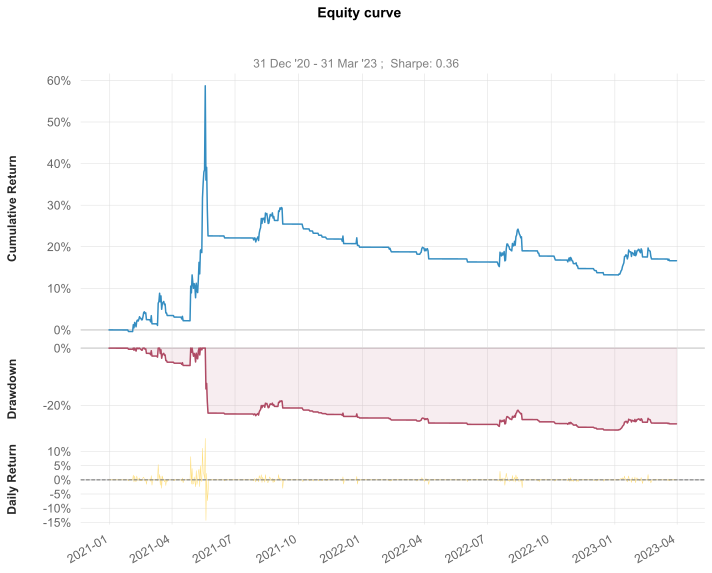

In [162]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

### Returns monthly breakdown

- Monthly returns
- Best day/week/month/year


/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



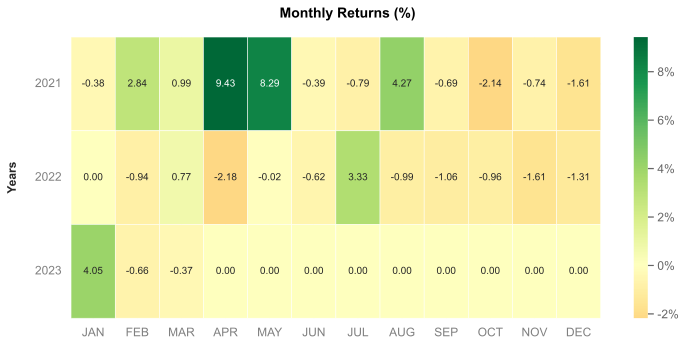

In [163]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

### Returns distribution

Show the difference between good and bad trading periods.

- Daily/montly/yearly

- Best/worst/avg.

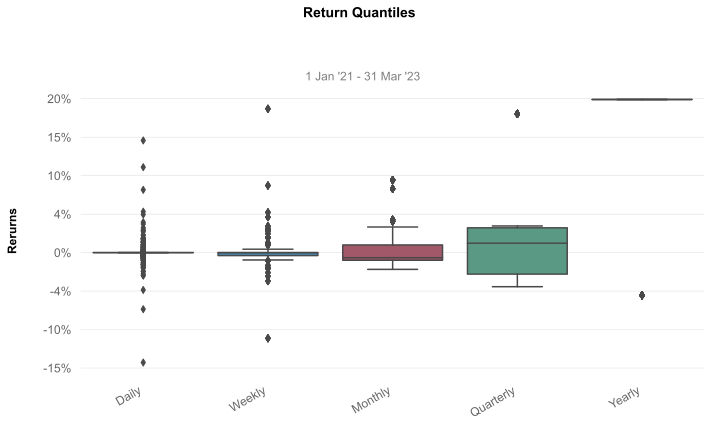

In [164]:
from tradeexecutor.visual.equity_curve import visualise_returns_distribution

visualise_returns_distribution(returns)

### Position chart

- Visualise individual positions over the price timeline

- Hover your mouse on the position marker circle to get its underlying details

- Positions closed for profit are marked green while losing ones are red

In [165]:
examined_candles = universe.universe.candles.get_candles_by_pair(examined_pair.internal_id)

figure2 = visualise_single_pair_positions_with_duration_and_slippage(
    state,
    examined_candles,
    start_at=START_AT,
    end_at=END_AT,
)

figure2.show()

### Benchmarks

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold any of our trading pairs


**Note**: This particular chart is not very useful as buy and hold MATIC vastly outperforms anything else.


In [166]:
from tradeexecutor.visual.benchmark import visualise_benchmark

# Benchmark strategy against buy and hold any of our traded assets
benchmarks = pd.DataFrame()
benchmarks.index = examined_candles.index
for pair_description in TRADING_PAIRS:
    token_symbol = pair_description[2]
    pair = universe.get_pair_by_human_description(pair_description)
    benchmarks[token_symbol] = universe.universe.candles.get_candles_by_pair(pair.internal_id)["close"]

fig = visualise_benchmark(
    "Bollinger bands example strategy",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    benchmark_indexes=benchmarks,
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

### Analyse trade statistics

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [167]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Trade summary

Overview of strategy performance



In [168]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

,0
Trading period length,782 days
Return %,16.63%
Annualised return %,7.76%
Cash at start,"$5,000.00"
Value at end,"$5,831.72"
Trade volume,"$92,434.56"
Position win percent,12.50%
Total positions,48
Won positions,6
Lost positions,42


## Trades per pair summary

Summary over different pairs

In [169]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
display(format_multipair_summary(multipair_summary))

,Trading pair,Positions,Trades,Total PnL USD,Best,Worst,Avg,Median,Volume,Wins,Losses,Take profits,Stop losses,Trailing stop losses
0,WMATIC-USDC,20,40,710.66,120.92%,-3.55%,4.50%,-2.32%,"38,209.02",2,2,0,18,0
1,WETH-USDC,12,24,586.59,25.77%,-4.18%,5.30%,-2.23%,"23,471.05",4,4,0,8,0
3,WAVAX-USDC,2,4,-53.64,-2.71%,-2.87%,-2.79%,-2.79%,"3,791.66",0,0,0,2,0
2,WBTC-USDC,14,28,-411.88,-2.18%,-5.79%,-3.01%,-2.59%,"26,962.84",0,0,0,14,0


### Position and trade timeline

Display all positions and how much profit they made.

In [170]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


Remarks,Opened at,Duration,Exchange,Base asset,Quote asset,Position max value,PnL USD,PnL %,Open mid price USD,Close mid price USD,Trade count,LP fees
SL,2021-01-27,9 hours 15 mins,Quickswap,WMATIC,USDC,$825.00,$-19.08,-2.31%,$0.039088,$0.038184,2,$0.82
,2021-02-03,20 days,Uniswap v2,WETH,USDC,$821.85,$142.20,17.30%,"$1,516.087050","$1,778.408902",2,$0.89
SL,2021-02-28,3 hours 30 mins,Quickswap,WMATIC,USDC,$845.31,$-25.75,-3.05%,$0.183776,$0.178178,2,$0.83
SL,2021-03-01,1 days 17 hours,Quickswap,WMATIC,USDC,$841.07,$-23.76,-2.82%,$0.216739,$0.210617,2,$0.83
SL,2021-03-10,2 hours 15 mins,Quickswap,WMATIC,USDC,$837.15,$-19.47,-2.33%,$0.273405,$0.267045,2,$0.83
,2021-03-11,14 days,Quickswap,WMATIC,USDC,$833.93,$119.01,14.27%,$0.282134,$0.322398,2,$0.89
SL,2021-04-03,9 hours 15 mins,Uniswap v2,WETH,USDC,$853.57,$-19.04,-2.23%,"$2,130.217373","$2,082.704858",2,$0.84
SL,2021-04-14,12 hours 45 mins,Uniswap v2,WBTC,USDC,$850.43,$-21.90,-2.58%,"$64,030.636827","$62,381.533972",2,$0.84
SL,2021-04-15,1 days 10 hours 45 mins,Uniswap v2,WETH,USDC,$846.82,$-21.51,-2.54%,"$2,425.728166","$2,364.099828",2,$0.84
,2021-04-27,26 days,Quickswap,WMATIC,USDC,$843.27,"$1,019.72",120.92%,$0.531930,$1.175166,2,$1.35


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [171]:
print("All ok")

All ok
